# Cassava image classification

In the EDA we saw that we have 5 classes in our dataset: <br>
0: Cassava Bacterial Blight (CBB)<br>
1: Cassava Brown Streak Disease (CBSD)<br>
2: Cassava Green Mottle (CGM)<br>
3: Cassava Mosaic Disease (CMD)<br>
4: Healthy<br>
Now, we want to automatically classify these images. Therefore, we are using convoultional networks. First we will set up the data and prepare it for the neural network. We will try out different approaches:
1. simple convultional network
2. pre-trained model

We will track our results using mlflow. 

## Import Libraries

Since we will download a dataset from kaggle, we have to hand over our kaggle handle. You can find the handle in your kaggle account. 

In [ ]:
#download kaggle api (kaggle.json) and import it here
from google.colab import files
files.upload()

In [ ]:
pip install -q tensorflow tensorflow-datasets

In [ ]:
pip install mlflow

In [34]:
#pip install tensorflow_datasets

In [1]:
import os, sys 
sys.path.append(os.path.dirname(os.path.realpath('/Users/paulosgidyelew/Desktop/cassava-classification-capstone/src')))
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, InputLayer, Dense, Dropout, BatchNormalization, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

import warnings
import mlflow

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, fbeta_score
from sklearn.utils import class_weight

import itertools, cv2
# user defined module
from src import f2,confusion_matrix


# mlflow parameters:
EXPERIMENT_NAME = "Classava_capstone"
TRACKING_URI = "https://hudsju377cddpoevnjdkfnvpwovniewnipcdsnkvn.mlflow.neuefische.de"

warnings.filterwarnings('ignore')

RSEED = 42
tf.random.set_seed(RSEED)

/Users/paulosgidyelew/Desktop/cassava-classification-capstone/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Following is a function that we will use in the notebook to plot a confusion matrix

## Loading the dataset

We will download the data from the kaggle website using the kaggle API. You need an account on kaggle to do this step. This step was already conducted at the beginning of the notebook.

In [ ]:
#download kaggle api (kaggle.json) and import it here
from google.colab import files
files.upload()

We have to create a directory for the Kaggle API

In [ ]:
# 600 permissions: only the owner has full read and write access to the API key (chmod=change mode)

!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Now let us download the data and unzip it

In [ ]:
#!kaggle competitions download -c cassava-leaf-disease-classification -p /content/ -f train.csv

In [ ]:
!kaggle competitions download -c cassava-disease -f train.zip
!kaggle competitions download -c cassava-disease -f test.zip

In [ ]:
!unzip train.zip > /dev/null
!unzip test.zip > /dev/null

We are also provided with the csv file that we have already seen in the EDA:

In [ ]:
#data = pd.read_csv('train.csv')
#data.head()

## Image Processing (Normalization and Augmentation)



>CNNs work by passing a series of filters (kernels) over an image to pull out patterns and features while reducing the number of parameters that the model has to tune.

>CNN is data hungry model that need to be fed large amounts of training images to get the desired performance. 
Exact number of images needed depends on the specific problem on hand, as a rule of thumb: 1,000 images from each class you are trying to classify (in our case at least 5,000 images)

>Where available data is limited, Keras’s ImageDataGenerator can be used to compensate that.

+ apply random transformations to each individual image as it is passed to the model so that it never sees the exact same image twice during training. 
+ These transformations are parameters on the generator that can be set when instantiated and can include:
  + rotations, shears, flips, and zooms. 
+ The benefit here is that the model will become more robust as it trains on images that are slightly distorted, and it helps to prevent the model from learning noise in your data such as where features are located in the image.

## Simple Convolutional Neural Network

Now we want to set up and run our first model. We chose a simple convolutional model in order to get a first glance at the results. We want to use this model as a low benchmark that we want to beat in more complex models that we will use afterwards. We were using the following tutorial as a guideline for the construction of the network: <a href= "https://www.youtube.com/watch?v=cAICT4Al5Ow&t=334s
">https://www.youtube.com/watch?v=cAICT4Al5Ow&t=334s</a>


First we will set up MLflow to keep track of our experiments

In [ ]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run(run_name='First, simple convolutional model')
run = mlflow.active_run()

Then we will create the architecture of the model. Here we are building three convolusional layers followed by one dense layers. Afterwards, we will compile the model and take a look at its summary. 

In [ ]:
model = Sequential()
model.add(Conv2D(64, 3, 3, input_shape=(380, 380, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5,'softmax'))

Additionaly, we can define a function to monitor the f2 score. The function was taken from the here:<a href="https://www.kaggle.com/ryanzhang/keras-f2-metric">https://www.kaggle.com/ryanzhang/keras-f2-metric</a> The function can be passed as a metric, when compiling the model.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

The ImageDataGenerator is used to produce the train and validation sets. We will use a validation split of 20%. the image data generator not only splits the data, but it also creates batches of data. Here we create batches with 32 images each (batch_size). Additionaly, the imagedatagenerator randomaly changes the images by rotating, shearing, zooming, or flipping them. This process makes the algorithm eventually more robust. Make sure that the shuffling option for the validation option is set to False. Otherwise, we cannot analyse our predictions later. 

In [ ]:
image_data_generator = ImageDataGenerator(rescale=1./255,
                                          rotation_range=90, 
                                          shear_range=0.2, 
                                          zoom_range=0.2, 
                                          horizontal_flip=True, 
                                          vertical_flip=True,
                                          validation_split=0.2
                                          )
                                          
train_set = image_data_generator.flow_from_directory('/content/train', 
                                                     subset='training', 
                                                     target_size=(380,380), 
                                                     class_mode='categorical', 
                                                     batch_size=32, 
                                                     shuffle=True,
                                                     interpolation='nearest',
                                                     color_mode="rgb",
                                                     )
val_set = image_data_generator.flow_from_directory('/content/train', 
                                                   subset='validation', 
                                                   target_size=(380,380), 
                                                   class_mode='categorical', 
                                                   batch_size=32, 
                                                   shuffle=False,
                                                   interpolation='nearest',  
                                                   color_mode="rgb"
                                                   )

Found 4527 images belonging to 5 classes.
Found 1129 images belonging to 5 classes.


We can look at the pictures and labels of one batch of the validation set:

In [ ]:
# We can have a look at the images and labels in the batches
# The first [i] determines the batch number and the second [i]  determines if we look at the images or its labels of this batch
val_set[1][1]

In [ ]:
val_set[1][0]

We can check out one instance of our set and its corresponding label:

[1. 0. 0. 0. 0.]


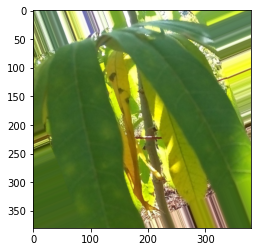

In [ ]:
plt.imshow(val_set[1][0][30])
print (val_set[1][1][30])

In [ ]:
# the amount of batches in the train set are:
len(train_set)

142

Now let us create a checkpoint, that will store the weights during the training. Then we will run the model (.fit) and save it in the vairbale 'history'. Later we can use the history to look at the progress of the accuracy and the loss. 

In [ ]:
model_checkpoint_filepath = 'checkpoints/simple_conv_model.ckpt'#h5
model_check_point = ModelCheckpoint(model_checkpoint_filepath,
                                    verbose=1, 
                                    save_weights_only=True, 
                                    monitor='val_loss', 
                                    save_best_only=True, 
                                    mode='auto'
                                    )
# the train_set contains both the features and the labels, so we do not have to define them separately
history = model.fit(train_set, 
                    epochs=10, 
                    verbose=1, 
                    callbacks=[model_check_point], 
                    validation_data=val_set, 
                    steps_per_epoch=len(train_set),
                    validation_steps=len(val_set)
                    )

The training gave us an accuracy of 0.57, a loss of 1.17

Let us plot the training-process.

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['training','validation'], loc='lower right')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Function')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc='upper right')
plt.show()

### Construction of the confusion matrix

In order to analyse the results, we should make a confusion matrix. Therefore, we have to make predictions on the validation set.

In [ ]:
# we can use model.predict to predict the validation set and argmax gives us the the highest number for each element
results = model.predict(val_set)
results = np.argmax(results, axis=1)

Let us create a classification report which will show us how the model performed for each class. 

In [ ]:
# report = classification_report(list_of_true_labels,results)
report = classification_report(val_set.classes, results)
print (report)

Now we can plot the confusion matrix. 

In [ ]:
cm = confusion_matrix(val_set.classes, results)
confusion_matrix.plot_confusion_matrix(
    cm, classes=['CBB', 'CBSD','CGM','CMD','Healthy'], 
    title='Pre-trained'
)

# Calculation of the F2 score

Since we are facing a problem of unbalanced data and we want to give more weight to the missclassification of classifying a plant as healthy when it is acutally sick, we want to use the F2_score

For the calulation of the F2 score there are two options: <b>'weighted'</b> or <b>'macro'</b>

CMD is <b>61.5%</b>,that of CBB <b>5.1%</b>, CBSD <b>10.2%</b>, CGM <b>11.2%</b> and a Healthy one<b>12.0%</b>

In the case of weighted average the performance metrics are weighted accordingly:

$score_{weighted\text{-}avg} = 0.051 \cdot score_{class\text{ }0} + 0.102 \cdot score_{class\text{ }1} + 0.112 \cdot score_{class\text{ }2} + ...$

Which will give us a higher F2 score due the class imbalance.

However, macro avg is not weighted and therefore:

$score_{macro\text{-}avg} = 0.5 \cdot score_{class\text{ }0} + 0.5 \cdot score_{class\text{ }1} + 0.5 \cdot score_{class\text{ }2} + ...$



In [ ]:
#Due to imbalance in our dataset we have to use 'macro' for averaging
F2_score = fbeta_score(val_set.classes,results, average='macro', beta=2)
print(F2_score)

Now let us save the parameters of the model to MLflow:

In [ ]:
# These are the parameters that will be transferred to MlFlow for logging our experiments

# Find meaningful parameters!
params = {
            "number of epochs": 10,
            "input_shape": val_set[0][0][0].shape,
            "confusion matrix":cm
        }

In [ ]:
# logging params to mlflow
mlflow.log_params(params)
# setting tags
mlflow.set_tag("colab", "True")
# logging metrics
mlflow.log_metric("train-" + "accuracy", history.history['accuracy'][-1])
mlflow.log_metric("val-" + "accuracy", history.history['val_accuracy'][-1])
mlflow.log_metric("train-" + "loss", history.history['loss'][-1])
mlflow.log_metric("val-" + "loss", history.history['val_loss'][-1])
mlflow.log_metric("F2-score", F2_score)

# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

### Alternative calculation of the confusion matrix

---
The following code was used previously to calculate the confusion matrix.
Let us make predictions on the validation set. We can use these predictions to make a confusion matrix

In [ ]:
# val_set.samples = 1889 and val_set.batch_size = 32
# val_steps_per_epoch = 60
val_steps_per_epoch = np.math.ceil(val_set.samples/val_set.batch_size)
predictions = model.predict_generator(val_set,steps=val_steps_per_epoch)

#get predictions high probability
predicted_classes = np.argmax(predictions, axis=1)

let us take a glimpse into a prediction:

In [ ]:
# gives prediction probability
predictions[:1]

In [ ]:
# takes the max prediction value from each sample
np.argmax(predictions[:1],axis=1)

With the predicted values we can now make a classification report which will give us useful inforamtion about recall, precision, accuracy and f1 score

In [ ]:
# val_true: [0,1,2,3,4,1,4,0,2,3,...]
# val_set.class_indices.keys(): dict_keys(['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy'])
val_true = val_set.classes
val_labels = list(val_set.class_indices.keys())
report2 = classification_report(val_true,predicted_classes,target_names=val_labels)
print(report2)

In [ ]:
#Due to imbalance in our dataset we have to use 'macro' for averaging
F2_score2 = fbeta_score(val_true, predicted_classes, average='macro', beta=2)
print(F2_score2)

Let us print the confusion matrix. Therefore, we are using a function (plot_confusion_matrix)

In [ ]:
cm2 = confusion_matrix(val_true,predicted_classes)

In [ ]:
confusion_matrix.plot_confusion_matrix(cm2, 
            classes=['CBB', 'CBSD','CGM','CMD','Healthy'], 
            title=''
            )

In [ ]:
 #scores_model = model.evaluate_generator(val_set)

In [ ]:
#scores_model

In [24]:
# %load '/Users/paulosgidyelew/Desktop/Cassava_Disease_Classifier/cassava-classification-capstone/src/f2.py'